In [132]:
import pandas as pd

df_train = pd.read_csv('twitter_training.csv',sep=',',header=None)
df_val = pd.read_csv('twitter_validation.csv',sep = ',', header=None)

In [133]:
df = pd.concat([df_train.assign(ind="train"), df_val.assign(ind="validation")])

In [134]:
df =df.iloc[:,-3:]
df.columns = ['sentiment','text','ind']

In [135]:
df = df.loc[(df['sentiment'] == 'Positive') | (df['sentiment'] == 'Negative')]

In [136]:
df.sentiment.describe()

count        43917
unique           2
top       Negative
freq         22808
Name: sentiment, dtype: object

In [137]:
df.loc[df['sentiment'] == 'Positive','sentiment'] = 1
df.loc[df['sentiment'] == 'Negative','sentiment'] = 0

In [138]:
#pip install spacy
#in terminal: python -m spacy download en_core_web_sm

import spacy
nlp = spacy.load('en_core_web_sm')
import re

In [139]:
df["text"] = df["text"].astype(str)
df["text"] = df['text'].apply(lambda x: " ".join([y.lemma_ for y in nlp(x) if not y.is_stop]))
df['text'] = df['text'].apply(lambda x: x.lower())
df['text'] = df['text'].apply((lambda x: re.sub('[^\w\s]','',x)))

In [140]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_features = 3000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df['text'].values)

In [141]:
df_train, df_val = df[df["ind"].eq("train")], df[df["ind"].eq("validation")]

In [142]:
X_train = tokenizer.texts_to_sequences(df_train['text'].values)
X_train = pad_sequences(X_train)

In [143]:
X_train.shape

(43374, 161)

In [144]:
X_val = tokenizer.texts_to_sequences(df_val['text'].values)
X_val = pad_sequences(X_val)

In [145]:
X_val.shape

(543, 28)

In [146]:
import numpy as np
X_val = np.lib.pad(X_val, ((0,0),(X_train.shape[1] - X_val.shape[1],0)), 'constant', constant_values=(0))
X_val.shape

(543, 161)

In [147]:
Y_train = np.array(pd.get_dummies((df_train['sentiment']).values))
Y_val = np.array(pd.get_dummies((df_val['sentiment']).values))

c:\Users\bruno\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [148]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

In [149]:
embed_dim = 128
lstm_out = 256
max_features = 3000

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X_train.shape[1]))
model.add(SpatialDropout1D(0.15))
model.add(LSTM(lstm_out, dropout=0.15, recurrent_dropout=0.15))
model.add(Dense(2,activation='sigmoid'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())
batch_size = 32

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 161, 128)          384000    
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 161, 128)         0         
 lDropout1D)                                                     
                                                                 
 lstm_3 (LSTM)               (None, 256)               394240    
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 778,754
Trainable params: 778,754
Non-trainable params: 0
_________________________________________________________________
None


In [150]:
model.fit(X_train, Y_train, epochs = 10, batch_size=batch_size, verbose = 2, shuffle=False)

Epoch 1/10
1356/1356 - 708s - loss: 0.5617 - accuracy: 0.7136 - 708s/epoch - 522ms/step
Epoch 2/10
1356/1356 - 646s - loss: 0.4120 - accuracy: 0.8133 - 646s/epoch - 476ms/step
Epoch 3/10
1356/1356 - 631s - loss: 0.3472 - accuracy: 0.8460 - 631s/epoch - 465ms/step
Epoch 4/10
1356/1356 - 636s - loss: 0.3010 - accuracy: 0.8679 - 636s/epoch - 469ms/step
Epoch 5/10
1356/1356 - 630s - loss: 0.3007 - accuracy: 0.8649 - 630s/epoch - 464ms/step
Epoch 6/10
1356/1356 - 658s - loss: 0.2442 - accuracy: 0.8936 - 658s/epoch - 486ms/step
Epoch 7/10
1356/1356 - 630s - loss: 0.2133 - accuracy: 0.9060 - 630s/epoch - 464ms/step
Epoch 8/10
1356/1356 - 621s - loss: 0.1837 - accuracy: 0.9197 - 621s/epoch - 458ms/step
Epoch 9/10
1356/1356 - 2603s - loss: 0.1607 - accuracy: 0.9283 - 2603s/epoch - 2s/step
Epoch 10/10
1356/1356 - 621s - loss: 0.1406 - accuracy: 0.9363 - 621s/epoch - 458ms/step


In [151]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, auc

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_lstm(model, X_test,Y_test):

    pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
    resultados = []

    for x in range(len(X_test)):
    
        result = model.predict(X_test[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 3)[0]
    
        if np.argmax(result) == np.argmax(X_test[x]):
            if np.argmax(X_test[x]) == 0:
                neg_correct += 1
            else:
                pos_correct += 1
        
        if np.argmax(X_test[x]) == 0:
            neg_cnt += 1
        else:
            pos_cnt += 1
        
        resultados.append(np.argmax(result))
    
    Y_test_argmax = np.argmax(Y_test,axis=1)
    Y_test_argmax  = Y_test_argmax.reshape(-1,1)
    resultados = np.asarray(resultados)
    resultados  = resultados.reshape(-1,1)

    conf_matrix = confusion_matrix(Y_test_argmax, resultados)
    fig = plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap = 'GnBu');
    plt.title("Confusion Matrix")
    plt.ylabel('Correct Class')
    plt.xlabel('Predicted class')
 
    return accuracy_score(Y_test_argmax, resultados), f1_score(Y_test_argmax, resultados, pos_label=1), fig

Accuracy:0.937
F1 Score: 0.940


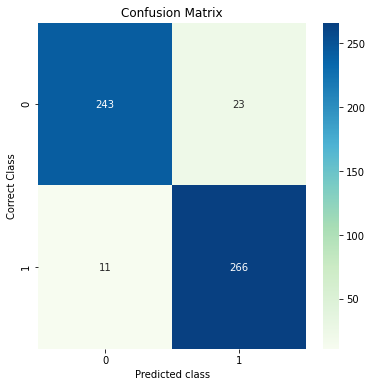

In [155]:
accuracy,f1, fig = evaluate_lstm(model,X_val,Y_val)
print(f'Accuracy:{accuracy:.3f}')
print(f'F1 Score: {f1:.3f}')